In [1]:
import scipy.fft
import numpy as np
import scipy.signal
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

#staviš tu load np.loadtxt() pogle 
# za FFT scipy.fff.rfft()
# rms obrisati dijelove koda

datoteka=np.loadtxt('new_data/ibp2m2_sl.csv',delimiter=",", skiprows=1)

# Ne treba ponovno loadirati datoteku svaki put.
emg_dat = datoteka[:, 1]
grip_dat = datoteka[:, 2]
time_dat = datoteka[:, 0]
# Data length
dat_len = time_dat.shape[0]
display(dat_len)
# Ispis
display(time_dat)
display(emg_dat)
display(grip_dat)
# Sampling rate - median daje bolje rezultate od prosjeka
sampling_rate = 1./np.median(np.diff(time_dat[10:-10])) # iz ROS skripte
display(sampling_rate)


26542

array([1.67093038e+09, 1.67093038e+09, 1.67093038e+09, ...,
       1.67093040e+09, 1.67093040e+09, 1.67093040e+09])

array([-10.223461, -10.223942, -10.220456, ..., -10.10547 , -10.092368,
       -10.084555])

array([0.507563  , 0.47151008, 0.50046882, ..., 1.18773874, 1.16952034,
       1.16633551])

992.969696969697

In [2]:
######################
# FFT treba napraviti na prozorima od 0.5s, kao što smo i u real-time-u s ROS-om radili
# Calculate window size for FFT - always round to nearest even number
fft_relative_window_size = 0.5
# Zaokružimo na najbliži cijeli broj - mora biti cijeli broj podataka pod prozorom
fft_window_size = round(fft_relative_window_size * sampling_rate)
# Parni broj točaka za FFT - 496 po mom izračunu ((990 / 2 = 495) + 1)
fft_window_size += (fft_window_size % 2)
display(f'fft_window: {fft_window_size}')
# FFT resolution
fft_resolution = sampling_rate / fft_window_size
display(f'fft_resolution: {fft_resolution}')
# Ukupan broj podataka mora biti višekratnik veličine prozora da bi obrada funkcionirala
# U real-time-u se podaci tako i obrađuju (kad ih se skupi 496)
# Reshape data to window_size × n array (disregard starting few points)
time_dat = time_dat[dat_len%fft_window_size:].reshape((-1, fft_window_size)) 
emg_dat = emg_dat[dat_len%fft_window_size:].reshape((-1, fft_window_size)) 
grip_dat = grip_dat[dat_len%fft_window_size:].reshape((-1, fft_window_size)) 
# Calculate RFFT on emg_data
emg_fft = scipy.fft.rfft(emg_dat)
# Ispis oblika matrica
display(f'time: {time_dat.shape}')
display(f'emg_dat: {emg_dat.shape}')
display(f'grip_dat: {grip_dat.shape}')
display(f'emg_fft: {emg_fft.shape}')
fft_dim = emg_fft.shape[1] # koliko je dugačak redak u fft
print (f'fft_dim: {fft_dim}')


'fft_window: 496'

'fft_resolution: 2.0019550342130987'

'time: (53, 496)'

'emg_dat: (53, 496)'

'grip_dat: (53, 496)'

'emg_fft: (53, 249)'

fft_dim: 249


In [3]:
import itertools
rolling_window_relative_size = [i/100 for i in range(1, 50)]
smoothing_factor = [i/1000 for i in range(50)]
#display(len(rolling_window_relative_size))
#display(len(smoothing_factor))

      
max_corrs_lags = []
max_corrs = []
roll_wind_size = []
smooth_fact = []

i = 0
for params in itertools.product(rolling_window_relative_size, smoothing_factor):
  i += 1
  # Random 0 - 1, 250 kom
  optimization_params = np.random.random(fft_dim)
  optimization_params = np.append(optimization_params, params)
  optimization_params[0] = 0 #uvijek nultu vrednost maknem skroz
  emg_ifft = scipy.fft.irfft(emg_fft * optimization_params[:fft_dim])
  rolling_window_size = round(optimization_params[fft_dim] * sampling_rate)
  emg_abs = np.abs(emg_ifft.ravel()) 
  window_ema = np.array([(1-optimization_params[fft_dim+1])**i for i in range(rolling_window_size)]) 
  window_ema = window_ema / window_ema.sum() 
  emg_ema = scipy.signal.fftconvolve(emg_abs, window_ema[::-1], mode='valid')
  grip_flat = grip_dat.ravel()[rolling_window_size-1:]
  emg_ema = emg_ema - emg_ema.mean()
  grip_flat = grip_flat - grip_flat.mean()
  corr_ema = scipy.signal.fftconvolve(emg_ema, grip_flat[::-1], mode='full')
  corr_ema /= (len(grip_flat) * emg_ema.std() * grip_flat.std())
  lags = scipy.signal.correlation_lags(len(emg_ema), len(grip_flat), mode='full')
  max_corr_lag_ema = lags[np.argmax(np.abs(corr_ema))]
  max_corr = np.abs(corr_ema).max()
  max_corrs_lags.append(max_corr_lag_ema)
  if max_corrs:
    if max_corr > np.max(max_corrs):
      optimal_params = optimization_params
  max_corrs.append(max_corr)
  roll_wind_size.append(params[0])
  smooth_fact.append(params[1])
  # if i < 5:
  #   display(optimization_params)

'Max correlation: 0.958917218514499'

'Lag at amx corr: 0.1893310546875'

'Optimal rolling_window_relative_size: 0.44'

'Optimal smoothing factor: 0.001'

<Figure size 432x288 with 0 Axes>

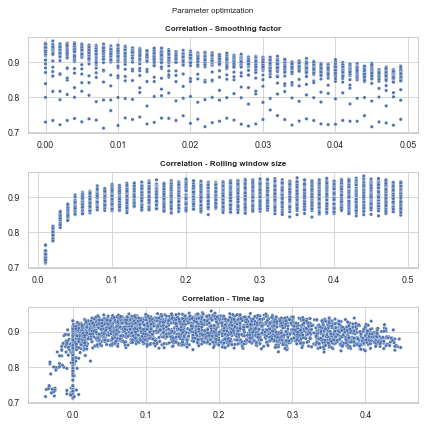

In [4]:
display(f'Max correlation: {np.max(max_corrs)}')
display(f'Lag at amx corr: {max_corrs_lags[np.argmax(max_corrs)]/sampling_rate}')
display(f'Optimal rolling_window_relative_size: {optimal_params[-2]}')
display(f'Optimal smoothing factor: {optimal_params[-1]}')

sns.set_theme(context='paper', style='whitegrid', rc={})
sns.despine()

fig, ax = plt.subplots(3, 1)
fig.set_size_inches(w=6., h=6.)
sns.scatterplot(
  x=smooth_fact,
  y=max_corrs,
  size=2.,
  legend=None,
  ax=ax[0]
)
ax[0].set_title('Correlation - Smoothing factor', fontsize='small', fontweight='bold')
sns.scatterplot(
  x=roll_wind_size,
  y=max_corrs,
  size=2.,
  legend=None,
  ax=ax[1]
)
ax[1].set_title('Correlation - Rolling window size', fontsize='small', fontweight='bold')
sns.scatterplot(
  x=max_corrs_lags/sampling_rate,
  y=max_corrs,
  size=2.,
  legend=None,
  ax=ax[2]
)
ax[2].set_title('Correlation - Time lag', fontsize='small', fontweight='bold')
# plt.plot(max_corrs_lags, max_corrs, 'o', size=2.)
# plt.grid(which='both')
plt.suptitle(t=r'Parameter optimization', fontsize='small')
plt.tight_layout()
fig.savefig('optimizacija.png', dpi=320)
plt.show()


'emg_ifft: (53, 496)'

'rolling_window_size: 437'

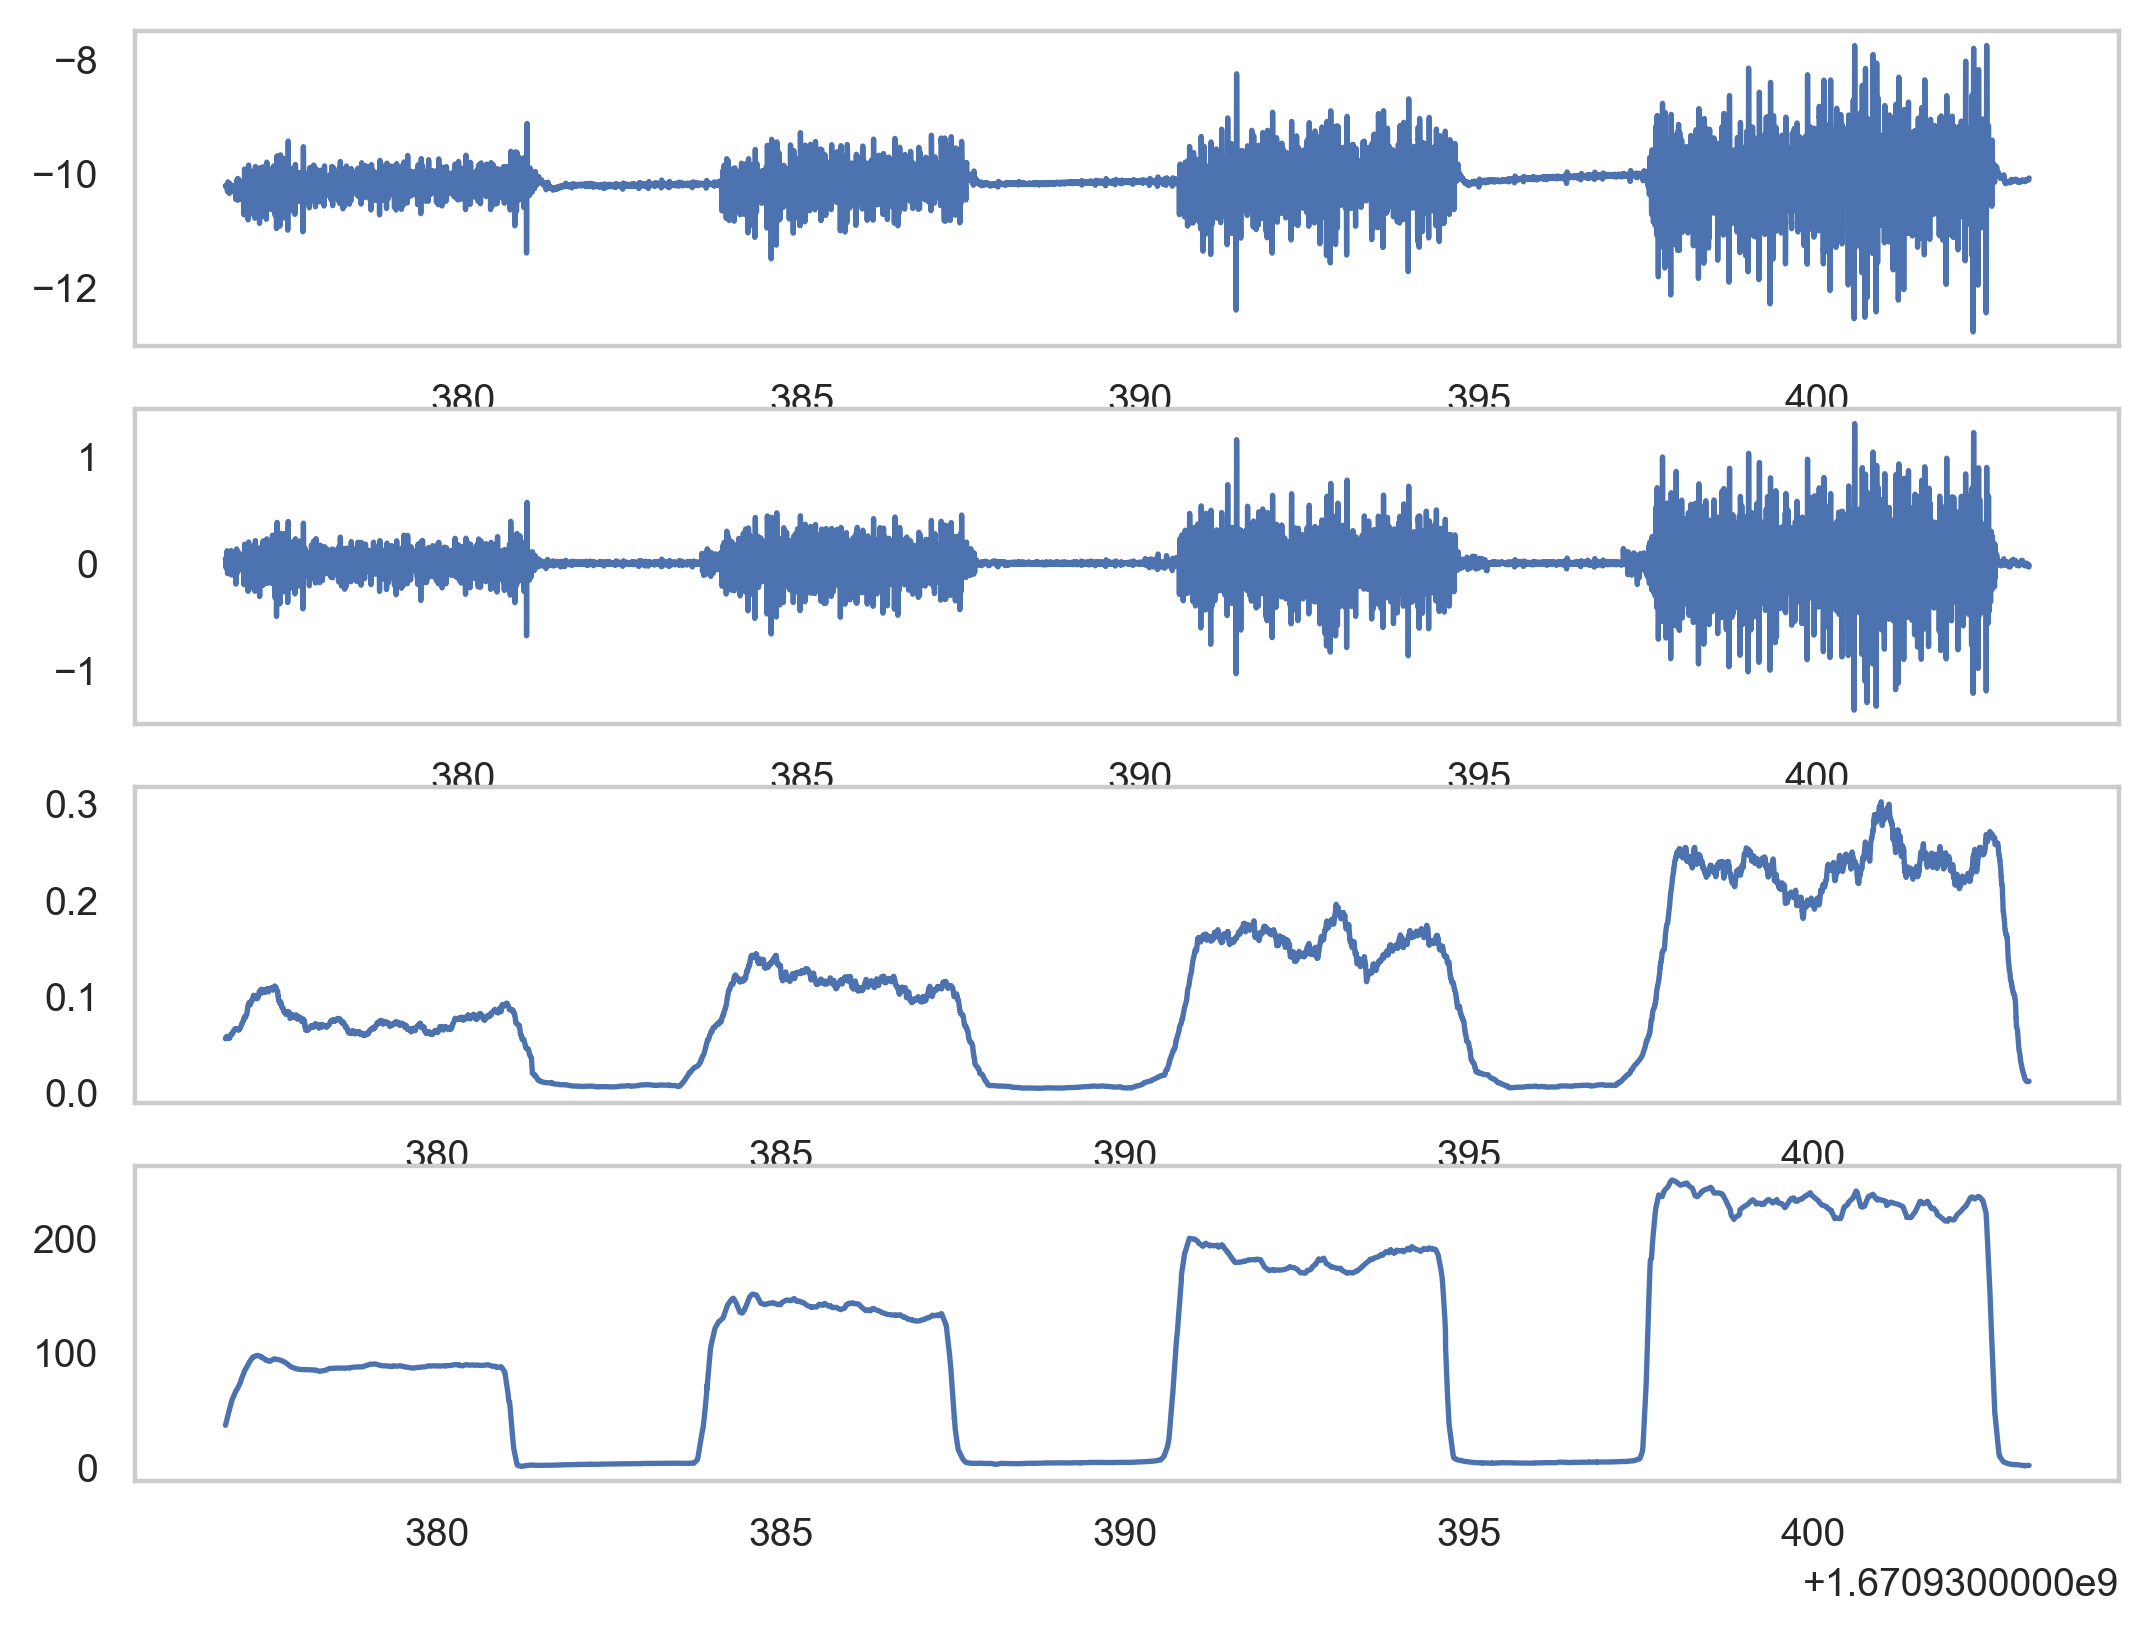

In [5]:
# Attenuation/amplification of single frequencies
# mijenajati FFT frekvencije množeći s vrijednostima [0, 1.5 - pojačanje]
# Kod vas je malo manji sampling rate pa umjesto 250 ima 249 frekvencija
# optimization_params = np.random.random(250)
# optimization_params = np.random.random(fft_dim)
# EMA relative window size -  u sekundama + ovaj random.random zapravo svaki 
# put kad pokrenete kod malo poveća/smanji rolling window jer ga pomnoži s
# random u rasponu (0, 1)
# rolling_window_relative_size = 0.25*random.random()
# optimization_params = np.append(optimization_params, rolling_window_relative_size)
# EMA smoothing factor - isto potebno optimirati, svaki put je malo drugačiji faktor
# zbog množenja
# smoothing_factor = 0.025 * random.random()
# optimization_params = np.append(optimization_params, smoothing_factor)
# DC offset always removed
# optimization_params[0] = 0 #uvijek nultu vrednost maknem skroz

# Optimal parameters after loop
optimization_params = optimal_params

# emg_fft se pomnoži s nekim brojevima [0, 1.5] da se zapravo filtrira signal
# i onda ide inverz da se rekonstruira početni signal + nekakvo filtriranje
emg_ifft = scipy.fft.irfft(emg_fft * optimization_params[:fft_dim])

# emg_ifft = scipy.fft.irfft (np.dot(emg_fft[:,None],optimization_params[None,:fft_dim]))
display(f'emg_ifft: {emg_ifft.shape}')
# Odredi se duljina prozora za EMA pomoću relativne duljine (u sekundama) i sampling
# rate-a
rolling_window_size = round(optimization_params[fft_dim] * sampling_rate)
# Ako je slučajno više od prozora za fft, zaokruži se na tu veličinu
display(f'rolling_window_size: {rolling_window_size}')
if rolling_window_size > fft_window_size:
  rolling_window_size  = fft_window_size

# Apsolutna vrijednost emg signala nakon filtriranja
# Ravel ga spljošti u 1D signal (spoji sve retke matrice u jedan)
emg_abs = np.abs(emg_ifft.ravel()) 
# EMA window - težine s kojima se množi signal
window_ema = np.array([(1-optimization_params[fft_dim+1])**i for i in range(rolling_window_size)]) 
# Normalizacija težina pomoću sume (suma svih težina = 1)
window_ema = window_ema / window_ema.sum() 
# EMA zaglađen emg signal (filtriranje + apsolutna + zaglađivanje)
emg_ema = scipy.signal.fftconvolve(emg_abs, window_ema[::-1], mode='valid')

# Plot
plt.figure(figsize=(8, 6), dpi=320)
plt.subplot(4, 1, 1)
# Original input signal
plt.plot(time_dat.ravel(), emg_dat.ravel())
plt.grid(which='both')
plt.subplot(4, 1, 2)
# Nakon filtriranja + rekostrukcije
plt.plot(time_dat.ravel(), emg_ifft.ravel())
plt.grid(which='both')
plt.subplot(4, 1, 3)
# Nakon apsolutne vrijednosti + zaglađivanja
plt.plot(time_dat.ravel()[rolling_window_size-1:], emg_ema)
plt.grid(which='both')
plt.subplot(4, 1, 4)
# Grip za usporedbu
plt.plot(time_dat.ravel()[rolling_window_size-1:], grip_dat.ravel()[rolling_window_size-1:])
plt.grid(which='both')
plt.show()

In [ ]:
# Vi zapravo optimirate ovih prvih 249 vrijednosti + jedna za rolling window size + jedna za smoothing factor
# Možete napraviti petlju ili nešto slično da ih pretražuje
display(optimization_params[:fft_dim].shape)
display(optimization_params[fft_dim])
display(optimization_params[fft_dim+1])

In [ ]:
display(time_dat.ravel()[rolling_window_size-1:].shape)
display(emg_ema.shape)
display(grip_dat.ravel()[rolling_window_size-1:].shape)

Cross-correlation with Pearson r

In [ ]:
grip_flat = grip_dat.ravel()[rolling_window_size-1:]
# Demean signals for 
emg_ema = emg_ema - emg_ema.mean()
grip_flat = grip_flat - grip_flat.mean()


In [ ]:

# corr_ema = scipy.signal.correlate(emg_ema, grip_flat, method='fft', mode='full')
# display(corr_ema)
corr_ema = scipy.signal.fftconvolve(emg_ema, grip_flat[::-1], mode='full')
corr_ema /= (len(grip_flat) * emg_ema.std() * grip_flat.std())
# display(corr_ema)
lags = scipy.signal.correlation_lags(len(emg_ema), len(grip_flat), mode='full')
print(f'EMA - GRIP:')
print(scipy.stats.pearsonr(emg_ema, grip_flat)[0])
max_corr_lag_ema = lags[np.argmax(np.abs(corr_ema))]
print(f'EMA -> Corr at 0 lag: {corr_ema[lags == 0]}')
print(f'EMA -> Max corr: {np.abs(corr_ema).max()}, Lag: {max_corr_lag_ema} or {max_corr_lag_ema/sampling_rate} sec')
plt.figure(figsize=(8, 6), dpi=320)
plt.plot(lags, corr_ema)
plt.legend(['EMA - GRIP'])
plt.grid(which='both')
plt.show()

In [ ]:
# %timeit corr_ema = scipy.signal.correlate(emg_ema, grip_flat, method='fft', mode='full')
corr_ema1 = scipy.signal.correlate(emg_ema, grip_flat, method='fft', mode='full')
display(corr_ema)
# %timeit corr_ema = scipy.signal.fftconvolve(emg_ema, grip_flat[::-1], mode='full')
corr_ema2 = scipy.signal.fftconvolve(emg_ema, grip_flat[::-1], mode='full')
display(corr_ema)
# %timeit corr_ema = np.convolve(emg_ema, grip_flat[::-1])
corr_ema3 = np.convolve(emg_ema, grip_flat[::-1])
display(corr_ema)
# %timeit corr_ema = np.correlate(emg_ema, grip_flat, mode='full')
corr_ema4 = np.correlate(emg_ema, grip_flat, mode='full')
np.allclose(corr_ema1, corr_ema4)

In [ ]:
import numba as nb
def rolling_window(emg_arr, window_size):
  shape = emg_arr.shape[:-1] + (emg_arr.shape[-1] - window_size + 1, window_size)
  strides = emg_arr.strides + (emg_arr.strides[-1],)
  return np.lib.stride_tricks.as_strided(emg_arr, shape=shape, strides=strides)


@nb.jit(nb.float64[:,:](nb.float64[:], nb.int64), nopython=True)
def rolling_window_nb(emg_arr, window_size):
  shape = emg_arr.shape[:-1] + (emg_arr.shape[-1] - window_size + 1, window_size)
  strides = emg_arr.strides + (emg_arr.strides[-1],)
  return np.lib.stride_tricks.as_strided(emg_arr, shape=shape, strides=strides)

In [ ]:
%timeit rolling_window_nb(grip, 500)
%timeit rolling_window(grip, 500)

In [ ]:
def exponential_ma(emg_rolling, decay, window_size):
  # ema_decay = 0.005
  window_ema = np.array([(1-decay)**i for i in range(window_size)])
  window_ema = window_ema / window_ema.sum()
  emg_abs = np.abs(emg_rolling)
  return scipy.signal.fftconvolve(emg_abs, window_ema[::-1], mode='valid')
  return np.average(np.abs(emg_rolling), axis=-1, weights=window_ema)

@nb.jit(nb.float64[:](nb.float64[:,:], nb.float64, nb.int64), nopython=True, fastmath=True)
def exponential_ma_nb(emg_rolling, decay, window_size):
  # ema_decay = 0.005
  window_ema = np.array([(1-decay)**i for i in range(window_size)])
  window_ema = window_ema / np.sum(window_ema)
  emg_abs = np.abs(emg_rolling)
  emg_ema = np.sum(emg_abs*window_ema, axis=-1)
  return emg_ema

In [ ]:
%timeit exponential_ma(b.ravel(), 0.005, window_size)
%timeit exponential_ma_nb(windowed_emg, 0.005, window_size)

In [ ]:
exponential_ma_nb(windowed_emg, 0.005, fft_window_size)
# scipy.signal.fftconvolve(np.abs(b.flat), window_ma[::-1], mode='valid')
# b
# windowed_emg

In [ ]:
np.all(np.isclose(
  exponential_ma(b.flat, 0.005, fft_window_size),
  exponential_ma_nb(windowed_emg, 0.005, fft_window_size)
  ))
# np.all(np.isclose(
#   exponential_ma(b.flat, 0.005, window_size), 
#   scipy.signal.fftconvolve(np.abs(b.flat), window_ma[::-1], mode='valid'),
#   ))